In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import timeit
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

%load_ext tensorboard

print("Using TensorFlow version %s" % tf.__version__)
#import tensorflow.experimental.numpy as tnp

Using TensorFlow version 2.3.0


In [2]:
#Model training and evaluation is same for any keras models-> Sequential, Functional APIs, subclassing models
#Input can be NumPy, tf.Numpy, eager tensors, tf.data.Datasets, pd.dataframe, python generators yielding batch of data and label
# Input data: Small & fits in memory-> NumPy arrays 
#             Large & distributed training needed -> tf.data Dataset objects
#             Large & lot of custom python modules needed for data preprocessing -> keras.utils.Sequence

# Training -> optimizers, losses, metrics

# Consider following Functional end-to-end MNIST dataset loaded as NumPy ararys:

In [3]:
# end to end example
# Functional Model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Load data and pre-process
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Training configuration
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# fit -> train model by slicing train set into 'batches' of 'batch_size' and iterate over the entire dataset for given 'epochs'
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

# loss value and metric values during training
history.history 

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 2s 3ms/step - loss: 0.3424 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.3438 - val_sparse_categorical_accuracy: 0.8922
Epoch 2/2
782/782 [==============================] - 2s 3ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.1515 - val_sparse_categorical_accuracy: 0.9583


{'loss': [0.34237003326416016, 0.1707540601491928],
 'sparse_categorical_accuracy': [0.9028000235557556, 0.9493399858474731],
 'val_loss': [0.34384363889694214, 0.15149162709712982],
 'val_sparse_categorical_accuracy': [0.8921999931335449, 0.958299994468689]}

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9518
test loss, test acc: [0.15645146369934082, 0.9517999887466431]
Generate predictions for 3 samples
predictions shape: (3, 10)


In [4]:
# compile()
# loss function, optimizer and metric(in list format)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# some string identfiers also exists:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [5]:
# compiled and uncomplied model functions for later usage:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [6]:
# Custom losses -> Two ways depending how you calculate loss:
# 1. If only y_pred and y_true reguired -> function method
# 2. If any extra parameter need other than y_{true,pred} -> function by sub-classing

# example for 1.
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

# Example for 2. Subclassing tf.keras.Loss requires __init__ and call:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

# Custom metrics
# Subclassing tf.keras.metrics.Metric class with __init__, update_state, result, reset_states
# following metric computes number of gtrue positives

class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)


782/782 [==============================] - 2s 2ms/step - loss: 0.0161


782/782 [==============================] - 2s 2ms/step - loss: 0.0385


Epoch 1/3
782/782 [==============================] - 2s 2ms/step - loss: 0.3406 - categorical_true_positives: 45094.0000
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1581 - categorical_true_positives: 47645.0000
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1169 - categorical_true_positives: 48211.0000


In [7]:
# add_loss and add_metric -> define them in a sub-class layer and add the layer while building model or add them in the end on the complete model

# losses and metrics which require non-standard signature
# Eg: loss from activation layer instead of output y_pred! 
# activity regularization loss example (built-in do exist):
# Method 1
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

# add_metric:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

# Method 2
# However, in functional API, easier way to implement this is:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 2.5176


782/782 [==============================] - 2s 2ms/step - loss: 0.3385 - std_of_activation: 1.0215


782/782 [==============================] - 2s 2ms/step - loss: 2.5052 - std_of_activation: 0.0020


In [8]:
# Consider a last layer which has metric and loss function in it. It takes logits and target as input 

class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)
    
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
# Next us
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)    

1/1 [==============================] - 0s 2ms/step - loss: 1.0913 - binary_accuracy: 0.0000e+00


In [9]:
# If you use NumPy, you can use validation_split, else validation data option always available
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 2s 3ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8943 - val_loss: 0.2492 - val_sparse_categorical_accuracy: 0.9245


In [10]:
# tf.data API
# Using tf.data.Dataset objects data
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
# NumPy to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset. datasets keeps getting reset at the end of epoch
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
#model.fit(train_dataset, epochs=3)
model.fit(train_dataset, epochs=1, validation_data=val_dataset)
# validation_steps=10 can be used but not validation_split for tf.data.Dataset

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

### Use only 100 batches per epoch -> steps_per_epoch
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)


782/782 [==============================] - 3s 4ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.2065 - val_sparse_categorical_accuracy: 0.9418


Evaluate
157/157 [==============================] - 1s 4ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9337


{'loss': 0.21471908688545227,
 'sparse_categorical_accuracy': 0.9337000250816345}

Epoch 1/3
100/100 [==============================] - 0s 3ms/step - loss: 0.8293 - sparse_categorical_accuracy: 0.7909
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3830 - sparse_categorical_accuracy: 0.8922
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3095 - sparse_categorical_accuracy: 0.9075


In [11]:
# keras.utils.Sequence object as input -> multiprocessing and shuffle!
# subclass it to get python generator with '__getitem__' and '__len__'
# __getitem__ should return complete batch
# if you want to modify data in between, implement on_epoch_end
# example: 
# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(tf.keras.utils.Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)

NameError: name 'filenames' is not defined

In [12]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np


In [13]:
# sample weights and class weights in model.fit(..class_weight={0:0.5})
#---------------------------------

# Need of class weights: give more imp, no need for balancing classes without respampling
# NumPy example of class weights:

import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

#---------------------------------

# Sample weights (array of numbers on how much weight each sample gets)
# NumPy data -> Model.fit(sample_weight)
# tf.data or any other iterator -> yield (input_batch, label_batch, sample_weights)

# Use: class imbalance, masking particular samples or classes in loss!

# NumPy input example:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

# tf.data.Dataset example:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)


Fit with class weight
782/782 [==============================] - 3s 3ms/step - loss: 0.3678 - sparse_categorical_accuracy: 0.9037


Fit with sample weight
782/782 [==============================] - 2s 3ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.9040


782/782 [==============================] - 3s 3ms/step - loss: 0.3634 - sparse_categorical_accuracy: 0.9040


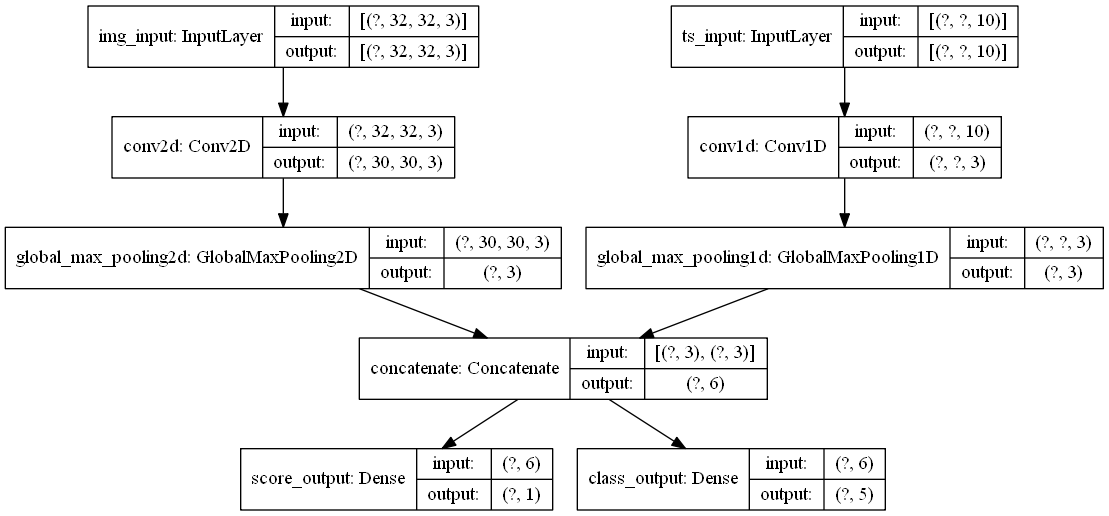

4/4 [==============================] - 0s 7ms/step - loss: 19.3151 - score_output_loss: 1.5346 - class_output_loss: 17.7805


4/4 [==============================] - 0s 7ms/step - loss: 18.6697 - score_output_loss: 0.9466 - class_output_loss: 17.7231


In [14]:
# Multi-input multi-output end-to-end example
# single input (764,) and single output example seen (10,)
# what if input is image (32,32,3) and timeseries steps (None, 10)..None=timesteps 10=features
# and output is score (1,) and probability distribution over 5 classes (5,)

#---------------------------------
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

#---------------------------------
# List Version
#model.compile(
#    optimizer=keras.optimizers.RMSprop(1e-3),
#    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
#    metrics=[
#        [
#            keras.metrics.MeanAbsolutePercentageError(),
#            keras.metrics.MeanAbsoluteError(),
#        ],
#        [keras.metrics.CategoricalAccuracy()],
#    ],
#)

# Dict version!
# better way since we gave names to output layer
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    # GIVING weights to different losses in total loss!!
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

#---------------------------------
# If you don't want to train some particular output node:

# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

#--------------------------------
# Passing data either as dict names as named in the layers or as list
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)


In [15]:
# Callbacks: Objects that are called at different points during training (start of epoch, end of batch, end of epoch)
# Need: validation at different points, checkpoint at some threshold crossing, changing learing rates in between, fine-tune layers in between, e=send email when done!!
# send it in Model.fit()

#-------------------------
# eg: EarlyStopping
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model = get_compiled_model()
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

#---------------
# eg: checkpoint model when some metric improves

model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

#----------------------------------------
# eg: checkpoint for fault-tolerance i.e restart if training stopped mid-way
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)


#--------------------
# eg: writing your own callback for saving a list of per-batch loss values
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))




Epoch 1/20
625/625 [==============================] - 2s 3ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.2377 - val_sparse_categorical_accuracy: 0.9295
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9459 - val_loss: 0.1880 - val_sparse_categorical_accuracy: 0.9427
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.1606 - val_sparse_categorical_accuracy: 0.9513
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1626 - val_sparse_categorical_accuracy: 0.9521
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.1422 - val_sparse_categorical_accuracy: 0.9570
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0705 - sparse_categorica

Epoch 1/2
623/625 [============================>.] - ETA: 0s - loss: 0.3769 - sparse_categorical_accuracy: 0.8940
Epoch 00001: val_loss improved from inf to 0.26152, saving model to mymodel_1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mymodel_1\assets
625/625 [==============================] - 4s 6ms/step - loss: 0.3767 - sparse_categorical_accuracy: 0.8940 - val_loss: 0.2615 - val_sparse_categorical_accuracy: 0.9239
Epoch 2/2
608/625 [============================>.] - ETA: 0s - loss: 0.1838 - sparse_categorical_accuracy: 0.9460
Epoch 00002: val_loss improved from 0.26152 to 0.19222, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2\assets
625/625 [==============================] - 5s 7ms/step - loss: 0.1830 - sparse_categorical_accuracy: 0.94

Restoring from ./ckpt/ckpt-loss=0.31
1563/1563 [==============================] - 38s 24ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.9561


In [16]:
#------------------
# Learning rates -> Static (scheduler method)and dynamic (callback method)
# static decay : Pass schedule to an optimizer
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

# dynamic decay: implement call back (ReduceLROnPlateau)

In [24]:
# Visualize loss and metric during training
# Tensorboard callback:
#%tensorboard --logdir logs/func

#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
stamp = 'test'
logdir = "logs/scalars/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

%tensorboard --logdir logs/scalars

1563/1563 [==============================] - 46s 29ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9806


Reusing TensorBoard on port 6006 (pid 17644), started 0:23:57 ago. (Use '!kill 17644' to kill it.)

In [27]:
%tensorboard --logdir="C:\Users\kbged\Downloads\tf guide\logs\scalars\test\events.out.tfevents.1610274084.DESKTOP-5DU3UD3.22204.305376.v2"

Reusing TensorBoard on port 6006 (pid 14136), started 0:01:19 ago. (Use '!kill 14136' to kill it.)

In [18]:
import pkg_resources

for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)

tensorboard 2.3.0
tensorboard-plugin-wit 1.6.0
